# Import the data (hubdub)

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

xml_data = open('hubdub.xml', 'r').read()  # Read file
root = ET.XML(xml_data)  # Parse XML

data = []
cols = []
q=dict()
for i, child in enumerate(root.findall("*/{http://gemofusion.gforge.inria.fr/xsd/datacorrob.xsd}Query")):
    q[child.attrib["id"]]=child.attrib["answer"]

for i, child in enumerate(root.findall("*/{http://gemofusion.gforge.inria.fr/xsd/datacorrob.xsd}Engine")):
    cols.append(child.attrib["id"])
    l = [child.find("{http://gemofusion.gforge.inria.fr/xsd/datacorrob.xsd}EngineAnswer[@ref='%s']"%(k)) for k in sorted(q)]
    l = map(lambda x: None if x==None else x.attrib["answer"], l)
    data.append(l)

In [2]:
q

{'m43108': 'Andy Murray',
 'm41935': 'LA Lakers',
 'm41921': 'Orlando wins series in 6 games',
 'm43061': '30-34',
 'm38684': 'LA Lakers - Orlando Magic',
 'm38922': 'Be&#351;ikta&#351; J.K.',
 'm43087': 'Philadelphia Phillies',
 'm43064': '280 and over',
 'm36415': 'BULLS',
 'm42594': 'No',
 'm19859': 'Chelsea',
 'm36416': 'South Africa',
 'm41348': 'Decided in 6 games',
 'm31882': 'Orlando Magic',
 'm43112': 'Safina wins in 2 sets',
 'm41912': 'LeBron James',
 'm37059': '4-5',
 'm41936': 'Western Conference',
 'm41361': '221 - 240 points',
 'm29570': '5',
 'm42440': 'Egypt',
 'm42591': 'Adelaide',
 'm42592': 'Collingwood',
 'm42590': 'Geelong',
 'm43113': 'Dominika Cibulkova',
 'm43109': 'Fernando Gonzalez',
 'm43018': 'No, combined score is less than 200 points',
 'm43016': 'No',
 'm43014': 'Orlando Magic',
 'm42931': 'Under 6.5',
 'm42912': 'Detroit Red Wings',
 'm43090': 'TX Rangers',
 'm43086': 'Milwaukee Brewers',
 'm43084': 'NY Yankees',
 'm43089': 'Chicago White Sox',
 'm43083

In [3]:
df = pd.DataFrame(data).T  # Write in DF and transpose it
#df.columns = cols  # Update column names
print(df)

      0                 1     2     3     4     5     6     7    \
0    None              None  None  None  None  None  None  None   
1    None              None  None  None  None  None  None  None   
2    None              None  None  None  None  None  None  None   
3    None              None  None  None  None  None  None  None   
4    None              None  None  None  None  None  None  None   
..    ...               ...   ...   ...   ...   ...   ...   ...   
352  None  Seattle Mariners  None  None  None  None  None  None   
353  None              None  None  None  None  None  None  None   
354  None              None  None  None  None  None  None  None   
355  None              None  None  None  None  None  None  None   
356  None              None  None  None  None  None  None  None   

                   8     9    ...   461   462   463   464   465   466  \
0                 None  None  ...  None  None  None  None  None  None   
1                 None  None  ...  None  None  No

## Matrix of the votes and the target of hubdub

In [4]:
a = df.to_numpy() #Vote Matrix
a[a==None]=0
print(a)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 'Boston Red Sox']
 [0 0 0 ... 0 0 0]]


In [5]:
b = [] #Target Matrix
for k in sorted(q):
    b.append(q[k])
b = np.array(b)
print(b[:10],'...')

['Yes' 'A Spanish team' 'Bordeaux' 'Barcelona' 'No' 'Other' 'No' 'Chelsea'
 'No' 'Yes'] ...


In [6]:
# Transform questions to binary questions by raising their numbers

votes = []
target = []
for i in range(len(a)):
    answers=[]
    for j in range(len(a[0])):
        if a[i][j]!=0 and not(a[i][j] in answers):
            answers.append(a[i][j])
    for answer in answers:
        temp = np.array([answer]*len(a[0]))
        votes.append(1*(a[i]!=0)*(a[i]==temp)-1*(a[i]!=0)*(a[i]!=temp)) 
        if answer == b[i]:
            target.append(1)
        else:
            target.append(0)
            
votes = np.array(votes)
target = np.array(target)

print(votes.shape) #The new matrix of votes 
print(target.shape) #The new matrix of answers

(830, 471)
(830,)


# 3-Estimates algorithm
With trust initialised at 0.1 instead of 0 to make it easier in MPC

In [7]:
def est3(v, iterations, target):
    nq, nv = v.shape
    trust = 0.1* np.ones((1, nv))  # voters trustworthiness
    diff = 0.1*np.ones((nq, 1))  # queries difficulty
    target.shape = (nq, 1)
    error = [] # We will measure the error on each iteration to track it
    
    t = (v==1)
    t_ = (v==-1)
    
    for it in range(iterations):
        n = np.sum(t,1) + np.sum(t_,1)
        pos = np.sum(t * (1 - np.matmul(diff, trust)), 1)
        neg = np.sum(t_ * np.matmul(diff, trust), 1)
        y = (pos + neg) / n
        y.shape = (nq, 1)
        
        n = np.sum(t,1)+np.sum(t_,1)
        pos = np.sum(t  * np.matmul((1 - y), 1 / trust), 1)
        neg = np.sum(t_ * np.matmul(y, 1 / trust), 1)
        diff = (pos + neg) / n
        diff.shape = (nq, 1)

        n = np.sum(t,0) + np.sum(t_,0)
        pos = np.matmul(t.transpose(), (1 - y) / diff)
        neg = np.matmul(t_.transpose(), y / diff)
        n.shape = pos.shape
        trust = (pos + neg) / n
        trust.shape = (1, nv)
        
        error.append(np.mean((np.array(y)>=0.5)!=target)) # % of votes that are wrong
        
    return np.array(y), np.array(trust), np.array(diff), error

In [8]:
#Testing on hubdub
y = est3(votes,500,target)

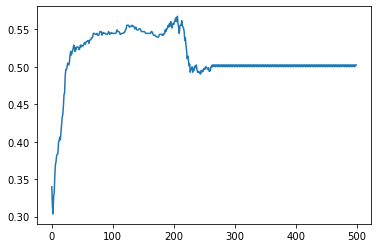

Error percentage on last iteration:  0.5024096385542168
The minimum number of errors was achieved on iteration number  3  and it had  252.0  errors.


In [9]:
plt.plot(y[-1])
plt.show() # % of errors on each iteration.
print('Error percentage on last iteration: ', y[-1][-1])
print('The minimum number of errors was achieved on iteration number ', np.argmin(y[-1])+1, ' and it had ', 830*np.min(y[-1]), ' errors.')

In [10]:
#Classic voting error:

answers = (np.sum(votes,1)>0)
answers.shape = target.shape
print('error percentage and number of errors with classic vote:')
print(np.mean(np.abs(answers!=target)), np.sum(np.abs(answers!=target)))

#SAME AS PAPER

error percentage and number of errors with classic vote:
0.3349397590361446 278


# Same code on bank notes authentification data:


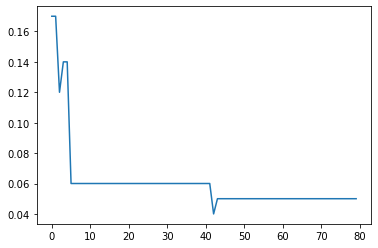

Error percentage on last iteration:  0.05


In [13]:
def get_array(file):
    file = open(file, 'rb')
    return pickle.load(file)

# Same code of 3est on bank data:
votes_bank, target_bank = get_array('votes-target.banknotes')
y = est3(votes_bank.transpose(),80,target_bank)
plt.plot(y[-1])
plt.show() # % of errors on each iteration.
print('Error percentage on last iteration: ', y[-1][-1])

In [14]:
#Classic voting error on bank data:
answers = (np.sum(votes_bank.transpose(),1)>0)
answers.shape = target_bank.shape
print('error percentage and number of errors with classic vote')
print(np.mean(np.abs(answers!=target_bank)), np.sum(np.abs(answers!=target_bank)))

error percentage and number of errors with classic vote
0.17 17


# Cosine on hubdub

In [23]:

def cosine(votes, iterations, target):
    v = votes.transpose()
    t = (v==1)
    t_ = (v==-1)
    nv, nq = v.shape
    error = []
    N = np.sum(v!=0, 1) # Number of {votes!=0}
    return 1/N, (np.sum(t, 1) - np.sum(t_, 1))
    trust = (np.sum(t, 1) - np.sum(t_, 1)) / N
    trust.shape = (nv, 1)
    N.shape = trust.shape

    y = np.ones(target.shape)
    e = np.mean(np.abs(target - (y>0)))
    print(e)
    error.append(e)
    eta = 0.2

    for iteration in range(iterations):
        pos = np.sum(y*t, 1)
        neg = np.sum(y*t_, 1)
        norm = np.sum((v!=0)*y**2, 1)*N
        norm = np.sqrt(norm)
        new_trust = (pos - neg)/norm
        new_trust.shape = (nv, 1)
        trust = trust*(1-eta) + new_trust*eta

        pos = np.sum(t*trust**3, 0)
        neg = np.sum(t_*trust**3, 0)
        norm = pos + neg
        y = (pos - neg) / norm

        e = np.mean(np.abs(target - (y > 0)))
        print(e)
        error.append(e)

    return y, error

In [26]:
y = cosine(votes,10,target)
plt.plot(y[-1])
plt.show() # % of errors on each iteration.
print('Error percentage on last iteration: ', y[-1][-1], y[-1][-1]*830)
print('The minimum number of errors was achieved on iteration number ', np.argmin(y[-1])+1, ' and it had ', 830*np.min(y[-1]), ' errors.')

0.5698795180722892


ValueError: operands could not be broadcast together with shapes (830,) (830,471) 

# For MPC

In [470]:
def map_to_ring(x):
    a = 2**20
    a = a * x
    a = np.rint(a)
    a = a.astype(int)
    a = a % 2**60
    return a

def secret_share(x, real=True, modulo=False):
    if not modulo:
        modulo = 2**60
    if real:
        x = map_to_ring(x)
    shares_partner = np.random.randint(0, modulo, x.shape)
    pickle.dump(shares_partner, open('hubdub.alice', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    shares_identity = (x - shares_partner).astype(int) % modulo
    pickle.dump(shares_identity, open('hubdub.bob', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)


In [471]:
secret_share(votes)

In [472]:
pickle.dump(target, open('hubdub.target', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [473]:
pickle.dump(votes, open('hubdub.votes', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)